## EODData NASDAQ + NYSE

The data has been acquired from http://www.eoddata.com/.  We are using tickers listed on <font color="red">NASDAQ</font> and <font color="red">NYSE</font> for last 20 years. Our goal is to find out change in dimensionality using PCA, MDS and Isomap.  The data set will give us a time series of dimension based on <font color="blue">PCA, MDS and Isomap</font>

### Load Equity EOD Prices from equity-prices.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import os.path

import sys

from sklearn import manifold
from numpy.linalg import svd
from scipy.spatial.distance import pdist
from numpy.linalg import norm

%matplotlib inline

In [19]:
def get_returns_daily_df(filename):
    """Load the data and calculate log return.  Remove the 
    first row because it will always be NaN."""
    df = pd.read_csv(filename)
    df.set_index(df['Dates'], inplace=True)
    df.drop('Dates', axis=1, inplace=True)
    df_ret = np.log(df / df.shift())
    return df_ret.ix[1:]

def get_svd_dimension(S, threshold=0.9):
    tot = sum(S)
    s_exp = [(i / tot) for i in sorted(S, reverse=True)]  # remove sorted
    cum_s_exp = np.cumsum(s_exp)        
    for i in range(0, cum_s_exp.shape[0]):        
        if cum_s_exp[i] >= threshold:
            return i
    return cum_s_exp.shape[0]    

# def get_eig_dimension(W, threshold=0.9):
#     """Calculate the dimension based on cumulative eigenvalue value percentages"""
#     tot = sum(W)
#     s_exp = [(i / tot) for i in sorted(W, reverse=True)]
#     cum_s_exp = np.cumsum(s_exp)        
#     for i in range(0, cum_s_exp.shape[0]):        
#         if cum_s_exp[i] >= threshold:
#             return i
#     return cum_s_exp.shape[0]    

def get_eig_dimension(S, threshold=0.9):
    """Calculate the dimension based on cumulative eigenvalue value percentages"""
    return get_svd_dimension(np.square(S), 0.9)

def get_svd_dim_gt_theta(S, theta = 0.01):
    """Calculate the dimension based on cumulative singular value percentages"""
    tot = sum(S)
    s_exp = [(i / tot) for i in sorted(S, reverse=True)]  # remove sorted
    s_gt_theta = [i for i in s_exp if i >= theta]
    return len(s_gt_theta)

def get_eig_dim_gt_theta(S, theta = 0.01):
    return get_svd_dim_gt_theta(np.square(S), 0.01)

def calc_dim_ts(df, width, knn=10):
    """Loop through using PCA, MDS and IsoMap"""
    max_rows = df.shape[0] - (width + 1)    
    dates = []
    pca_svd_dimensions = []
    mds_svd_dimensions = []
    isomap_svd_dimensions = []

    pca_eig_dimensions = []
    mds_eig_dimensions = []
    isomap_eig_dimensions = []

    pca_svd_gt = []
    mds_svd_gt = []
    isomap_svd_gt = []
    
    pca_eig_gt = []
    mds_eig_gt = []
    isomap_eig_gt = []
    
    threshold = 0.9
    
    for i in range(0, max_rows):           
        data = df[i:i+width].copy()
        orig_cols_len = len(data.columns)
#         data.dropna(axis=1, inplace=True)  # ori_data.dropna(inplace=True)
#         data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
        data.replace([np.inf, -np.inf], np.nan, inplace=True)
        data.dropna(axis=1, inplace=True)
        new_cols_len = len(data.columns)
        ds = df.index[i+width]

        s = '%d.)  orig_cols_len=%d   new_cols_len=%d    date=%s\n' % (i, orig_cols_len, new_cols_len, ds)
        logger.write(s)
        
        if new_cols_len < 100:
            continue
            
        
        # ---------------------------------------------------------------------------------------------------------
        # PCA/SVD
        try:
            U, S, V = np.linalg.svd(data)
            svd_dim = get_svd_dimension(S, threshold)
            pca_svd_dimensions.append(svd_dim)

    #         W, V = np.linalg.eig(data)
            eig_dim = get_eig_dimension(S, threshold)        
            pca_eig_dimensions.append(eig_dim)

            svd_gt = get_svd_dim_gt_theta(S, 0.01)
            pca_svd_gt.append(svd_gt)

            eig_gt = get_eig_dim_gt_theta(S, 0.01)
            pca_eig_gt.append(eig_gt)

            s = 'SVD PCA = %d  SVG_PCA_GT = %d\n' % (svd_dim, svd_gt)
            logger.write(s)
        except:
            print("Unexpected error:", sys.exc_info()[0])
        
        # ---------------------------------------------------------------------------------------------------------
        # MDS
        Y = manifold.MDS(n_components=width, max_iter=300, n_init=4).fit_transform(data)
        Y = Y[:,~np.all(np.isnan(Y), axis=0)]
        U, S, V = np.linalg.svd(Y)
        svd_dim = get_svd_dimension(S, threshold)
        mds_svd_dimensions.append(svd_dim)
        
#         W, V = np.linalg.eig(Y)
        eig_dim = get_eig_dimension(S, threshold)        
        mds_eig_dimensions.append(eig_dim)
        
        svd_gt = get_svd_dim_gt_theta(S, 0.01)
        mds_svd_gt.append(svd_gt)
        
        eig_gt = get_eig_dim_gt_theta(S, threshold)
        mds_eig_gt.append(eig_gt)                
        
        s = 'SVD MDS = %d   SVG_MDS_GT = %d\n' % (svd_dim, svd_gt)
        logger.write(s)


        # ---------------------------------------------------------------------------------------------------------
        # IsoMap
        Y = manifold.Isomap(n_neighbors=knn, n_components=width).fit_transform(data)
        Y = Y[:,~np.all(np.isnan(Y), axis=0)]
        U, S, V = np.linalg.svd(Y)
        svd_dim = get_svd_dimension(S, threshold)
        isomap_svd_dimensions.append(svd_dim)
        
#         W, V = np.linalg.eig(Y)
        eig_dim = get_eig_dimension(S, threshold)        
        isomap_eig_dimensions.append(eig_dim)
        
        svd_gt = get_svd_dim_gt_theta(S, 0.01)
        isomap_svd_gt.append(svd_gt)
        
        eig_gt = get_eig_dim_gt_theta(S, threshold)
        isomap_eig_gt.append(eig_gt)                
        
        
        s = 'SVD ISO = %d   SVG_ISO_GT = %d\n' % (svd_dim, svd_gt)
        logger.write(s)
        
        dates.append(ds)
        logger.write('------------------------------------------------------------------------\n')
        logger.flush()
        
    df1 = pd.DataFrame()
    df1['Dates'] = dates
    df1['PCA_SVD_DIMS'] = pca_svd_dimensions
    df1['MDS_SVD_DIMS'] = mds_svd_dimensions
    df1['ISO_SVD_DIMS'] = isomap_svd_dimensions

    df1['PCA_EIG_DIMS'] = pca_eig_dimensions
    df1['MDS_EIG_DIMS'] = mds_eig_dimensions
    df1['ISO_EIG_DIMS'] = isomap_eig_dimensions

    df1['PCA_SVD_GT'] = pca_svd_gt
    df1['MDS_SVD_GT'] = mds_svd_gt
    df1['ISO_SVD_GT'] = isomap_svd_gt

    df1['PCA_EIG_GT'] = pca_eig_gt
    df1['MDS_EIG_GT'] = mds_eig_gt
    df1['ISO_EIG_GT'] = isomap_eig_gt
    
    return df1


def get_csv_filename(width):
    save_path = r'C:\phd\log'
    name_of_file =  str(width) + '.csv'
    file_name = os.path.join(save_path, name_of_file)
    return file_name

## Equity Prices

In [10]:
save_path = r'C:\phd\log'
name_of_file = 'eoddata-equity-prices.log'
log_file_name = os.path.join(save_path, name_of_file)
logger = open(log_file_name, 'w')

logger.write('Process started\n')
logger.write('Loading EODDATA equity prices\n')

df = get_returns_daily_df(r'C:\phd\data\eoddata\equity-price.csv')
df = df.round(7)
logger.write('File loaded successfully\n')

widths = [60]
for width in widths:
    df_dim_ts = calc_dim_ts(df, width)
    file_name = get_csv_filename(width)
    df_dim_ts.to_csv(file_name)
    logger.write('EODDATA Equity Prices dimensionality time series for width %d generated.  Now plot.\n' % width)    
logger.close()

## Equity Volume

In [12]:
save_path = r'C:\phd\log'
name_of_file = 'eoddata-equity-volume.log'
log_file_name = os.path.join(save_path, name_of_file)
logger = open(log_file_name, 'w')

logger.write('Process started\n')
logger.write('Loading EODDATA equity volume\n')

df = get_returns_daily_df(r'C:\phd\data\eoddata\equity-volume.csv')
df = df.round(7)
logger.write('File loaded successfully\n')

widths = [60]
for width in widths:
    df_dim_ts = calc_dim_ts(df, width)
    file_name = get_csv_filename(width)
    df_dim_ts.to_csv(file_name)
    logger.write('EODDATA Equity volume dimensionality time series for width %d generated.  Now plot.\n' % width)    
logger.close()

## Futures Price

In [14]:
save_path = r'C:\phd\log'
name_of_file = 'eoddata-futures-price.log'
log_file_name = os.path.join(save_path, name_of_file)
logger = open(log_file_name, 'w')

logger.write('Process started\n')
logger.write('Loading EODDATA futures price\n')

df = get_returns_daily_df(r'C:\phd\data\eoddata\futures-price.csv')
df = df.round(7)
logger.write('File loaded successfully\n')

widths = [60]
for width in widths:
    df_dim_ts = calc_dim_ts(df, width)
    file_name = get_csv_filename(width)
    df_dim_ts.to_csv(file_name)
    logger.write('EODDATA Futures price dimensionality time series for width %d generated.  Now plot.\n' % width)    
logger.close()

## Futures Volume 

In [ ]:
save_path = r'C:\phd\log'
name_of_file = 'eoddata-futures-volume.log'
log_file_name = os.path.join(save_path, name_of_file)
logger = open(log_file_name, 'w')

logger.write('Process started\n')
logger.write('Loading EODDATA futures volume\n')

df = get_returns_daily_df(r'C:\phd\data\eoddata\futures-volume.csv')
df = df.round(7)
logger.write('File loaded successfully\n')

# -------------------------------------------------------------------------------------
# after loading the data run the experiment
widths = [60]
for width in widths:
    df_dim_ts = calc_dim_ts(df, width)
    file_name = get_csv_filename(width)
    df_dim_ts.to_csv(r'C:\phd\output\eoddata\eoddata-futures-volume-60.csv')
    logger.write('EODDATA Futures volume dimensionality time series for width %d generated.  Now plot.\n' % width)    
logger.close()

## Futures Open Interest

In [ ]:
save_path = r'C:\phd\log'
name_of_file = 'eoddata-futures-openinterest.log'
log_file_name = os.path.join(save_path, name_of_file)
logger = open(log_file_name, 'w')

logger.write('Process started\n')
logger.write('Loading EODDATA futures open interest\n')

df = get_returns_daily_df(r'C:\phd\data\eoddata\futures-openinterest.csv')
df = df.round(7)
logger.write('File loaded successfully\n')

# -------------------------------------------------------------------------------------
# after loading the data run the experiment
widths = [60]
for width in widths:
    df_dim_ts = calc_dim_ts(df, width)
    file_name = get_csv_filename(width)
    df_dim_ts.to_csv(r'C:\phd\output\eoddata\eoddata-futures-openinterest-60.csv')
    logger.write('EODDATA Futures open interest dimensionality time series for width %d generated.  Now plot.\n' % width)    
logger.close()

In [6]:
def get_returns_df():
    """Load the data and calculate log return.  Remove the 
    first row because it will always be NaN."""
    df = pd.read_csv('russell3000.csv')
    df.set_index(df['Dates'], inplace=True)
    df.drop('Dates', axis=1, inplace=True)
    df_ret = np.log(df / df.shift())
    df_ret.drop(['1/2/1986'], inplace=True)
    return df_ret


def calc_isomap_dim_ts(df, width):
    """Loop through for isomap with different knn/width IsoMap"""
    max_rows = df.shape[0] - (width + 1)    
    dates = []
    isomap_svd_dim_k10 = []
    isomap_eig_dim_k10 = []
    isomap_svd_dim_k20 = []
    isomap_eig_dim_k20 = []
    isomap_svd_dim_k30 = []
    isomap_eig_dim_k30 = []
    isomap_svd_dim_k40 = []
    isomap_eig_dim_k40 = []
    isomap_svd_dim_k50 = []
    isomap_eig_dim_k50 = []
    
    threshold = 0.9
    knns = [10, 20, 30, 40, 50]
    for i in range(0, max_rows):
        data = df[i:i+width].copy()
        orig_cols_len = len(data.columns)
        data.dropna(axis=1, inplace=True)
        new_cols_len = len(data.columns)
        ds = df.index[i+width]
        
        s = '%d.)  orig_cols_len=%d   new_cols_len=%d    date=%s\n' % (i, orig_cols_len, new_cols_len, ds)
        logger.write(s)
        
        # IsoMap
        for knn in knns:
            Y = manifold.Isomap(n_neighbors=knn, n_components=width).fit_transform(data)
            Y = Y[:,~np.all(np.isnan(Y), axis=0)]
            U, S, V = np.linalg.svd(Y)
            svd_dim = get_svd_dimension(S, threshold)
            eig_dim = get_eig_dimension(S, threshold)
            if knn == 10:
                isomap_svd_dim_k10.append(svd_dim)
                isomap_eig_dim_k10.append(eig_dim)
            elif knn == 20:
                isomap_svd_dim_k20.append(svd_dim)
                isomap_eig_dim_k20.append(eig_dim)
            elif knn == 30:
                isomap_svd_dim_k30.append(svd_dim)
                isomap_eig_dim_k30.append(eig_dim)
            elif knn == 40:
                isomap_svd_dim_k40.append(svd_dim)
                isomap_eig_dim_k40.append(eig_dim)
            elif knn == 50:
                isomap_svd_dim_k50.append(svd_dim)
                isomap_eig_dim_k50.append(eig_dim)

            s = 'knn = %d    width = %d    SVD ISO = %d   EIG ISO = %d\n' % (knn, width, svd_dim, eig_dim)
            logger.write(s)
        
        dates.append(ds)
        logger.write('------------------------------------------------------------------------\n')
                        
    df1 = pd.DataFrame()
    df1['Dates'] = dates
    df1['ISO_SVD_DIM_K10'] = isomap_svd_dim_k10
    df1['ISO_EIG_DIM_K10'] = isomap_eig_dim_k10
    
    df1['ISO_SVD_DIM_K20'] = isomap_svd_dim_k20
    df1['ISO_EIG_DIM_K20'] = isomap_eig_dim_k20
    
    df1['ISO_SVD_DIM_K30'] = isomap_svd_dim_k30
    df1['ISO_EIG_DIM_K30'] = isomap_eig_dim_k30
    
    df1['ISO_SVD_DIM_K40'] = isomap_svd_dim_k40
    df1['ISO_EIG_DIM_K40'] = isomap_eig_dim_k40
    
    df1['ISO_SVD_DIM_K50'] = isomap_svd_dim_k50
    df1['ISO_EIG_DIM_K50'] = isomap_eig_dim_k50

    
    return df1

#### Moving window size for calculating dimensionality reduction

In [4]:
def get_csv_filename(width):
    save_path = 'C:\\workspace\\nldr\\log'
    name_of_file =  str(width) + '.csv'
    file_name = os.path.join(save_path, name_of_file)
    return file_name

def get_isomap_csv_filename(width):
    save_path = 'C:\\workspace\\nldr\\log'
    name_of_file =  'isomap_' + str(width) + '.csv'
    file_name = os.path.join(save_path, name_of_file)
    return file_name

# <font color="red">Just run code above it.  Output is saved in file</font>

# Isomap with different k and window width

In [7]:
widths = [60]
for width in widths:
    df_dim_ts = calc_isomap_dim_ts(df, width)
    file_name = get_isomap_csv_filename(width)
    df_dim_ts.to_csv(file_name)
    logger.write('Isomap dimensionality time series for width %d generated.  Now plot.\n' % width)    
logger.close()

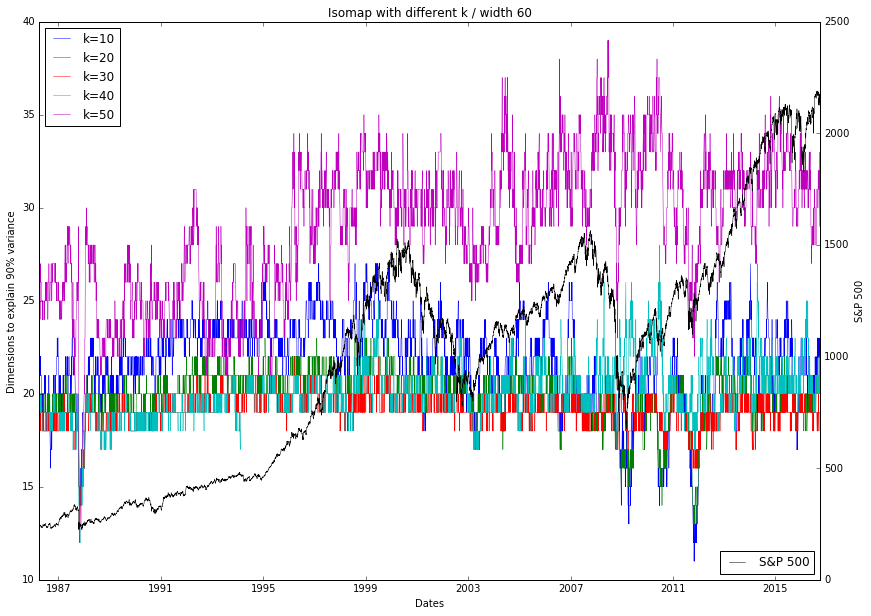

In [10]:
df = pd.read_csv('isomap_60.csv')

ts = pd.to_datetime(df['Dates'], format='%m/%d/%Y')

fig, ax1 = plt.subplots(figsize=(14,10))
ax2 = ax1.twinx()
l1 = ax1.plot(ts, df['ISO_EIG_DIM_K10'], 'b', label='k=10', linewidth=0.5)
l2 = ax1.plot(ts, df['ISO_EIG_DIM_K20'], 'g', label='k=20', linewidth=0.5)
l3 = ax1.plot(ts, df['ISO_EIG_DIM_K30'], 'r', label='k=30', linewidth=0.5)
l4 = ax1.plot(ts, df['ISO_EIG_DIM_K40'], 'c', label='k=40', linewidth=0.5)
l5 = ax1.plot(ts, df['ISO_EIG_DIM_K50'], 'm', label='k=50', linewidth=0.5)
ax1.legend(loc='upper left')

l6 = ax2.plot(ts, df['SP500'], 'k', label='S&P 500', linewidth=0.5)
ax2.legend(loc='lower right')

ax1.set_xlabel('Dates')
ax1.set_ylabel('Dimensions to explain 90% variance')
ax2.set_ylabel('S&P 500')

title = 'Isomap with different k / width 60'
plt.title(title)

# plt.savefig('all3.pdf')
plt.show()

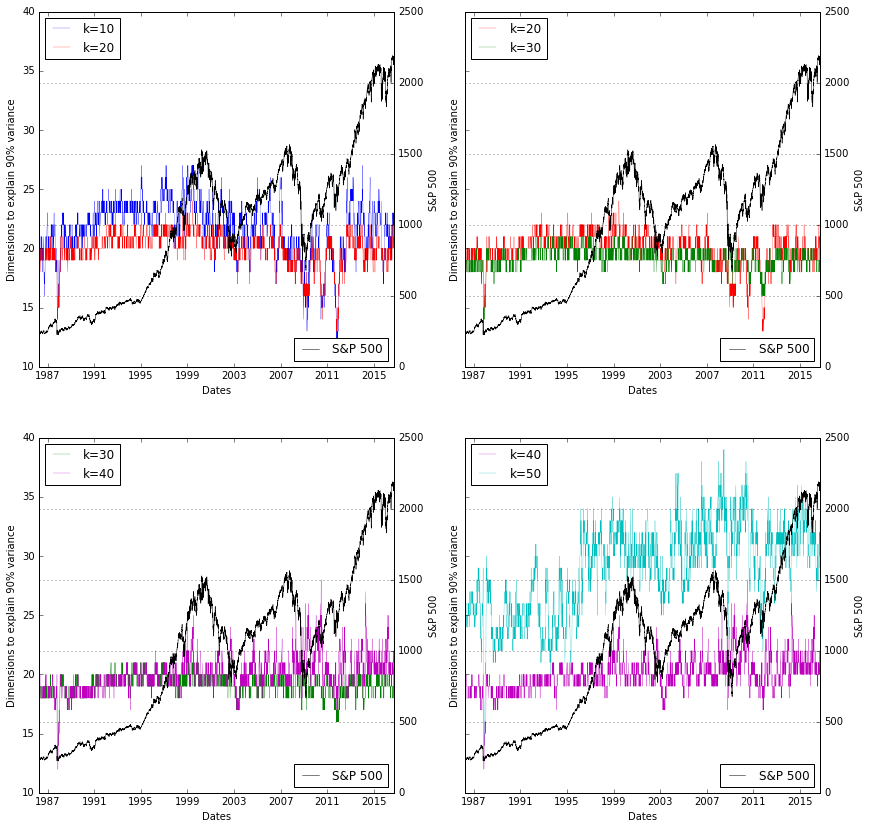

In [26]:
# plot with various axes scales
# plt.figure(1)
f, axarr = plt.subplots(2, 2, figsize=(14,14), sharey=True)

ax1 = axarr[0,0]
ax2 = axarr[0,1]
ax3 = axarr[1,0]
ax4 = axarr[1,1]

# linear
ax12 = ax1.twinx()
l1 = ax1.plot(ts, df['ISO_EIG_DIM_K10'], 'b', label='k=10', linewidth=0.25)
l2 = ax1.plot(ts, df['ISO_EIG_DIM_K20'], 'r', label='k=20', linewidth=0.25)
l6 = ax12.plot(ts, df['SP500'], 'k', label='S&P 500', linewidth=0.5)
ax1.legend(loc='upper left')
ax12.legend(loc='lower right')
ax1.set_xlabel('Dates')
ax1.set_ylabel('Dimensions to explain 90% variance')
ax12.set_ylabel('S&P 500')
plt.grid(True)


# log
ax22 = ax2.twinx()
l1 = ax2.plot(ts, df['ISO_EIG_DIM_K20'], 'r', label='k=20', linewidth=0.25)
l2 = ax2.plot(ts, df['ISO_EIG_DIM_K30'], 'g', label='k=30', linewidth=0.25)
l6 = ax22.plot(ts, df['SP500'], 'k', label='S&P 500', linewidth=0.5)
ax2.legend(loc='upper left')
ax22.legend(loc='lower right')
ax2.set_xlabel('Dates')
ax2.set_ylabel('Dimensions to explain 90% variance')
ax22.set_ylabel('S&P 500')
plt.grid(True)

ax32 = ax3.twinx()
l1 = ax3.plot(ts, df['ISO_EIG_DIM_K30'], 'g', label='k=30', linewidth=0.25)
l2 = ax3.plot(ts, df['ISO_EIG_DIM_K40'], 'm', label='k=40', linewidth=0.25)
l6 = ax32.plot(ts, df['SP500'], 'k', label='S&P 500', linewidth=0.5)
ax3.legend(loc='upper left')
ax32.legend(loc='lower right')
ax3.set_xlabel('Dates')
ax3.set_ylabel('Dimensions to explain 90% variance')
ax32.set_ylabel('S&P 500')
plt.grid(True)

ax42 = ax4.twinx()
l1 = ax4.plot(ts, df['ISO_EIG_DIM_K40'], 'm', label='k=40', linewidth=0.25)
l2 = ax4.plot(ts, df['ISO_EIG_DIM_K50'], 'c', label='k=50', linewidth=0.25)
l6 = ax42.plot(ts, df['SP500'], 'k', label='S&P 500', linewidth=0.5)
ax4.legend(loc='upper left')
ax42.legend(loc='lower right')
ax4.set_xlabel('Dates')
ax4.set_ylabel('Dimensions to explain 90% variance')
ax42.set_ylabel('S&P 500')
plt.grid(True)

# # symmetric log
# fig, ax1 = plt.subplot(223)
# ax2 = ax1.twinx()
# l1 = ax1.plot(ts, df['ISO_EIG_DIM_K30'], 'b', label='k=10', linewidth=0.5)
# l6 = ax2.plot(ts, df['SP500'], 'k', label='S&P 500', linewidth=0.5)
# ax1.legend(loc='upper left')
# ax2.legend(loc='lower right')
# ax1.set_xlabel('Dates')
# ax1.set_ylabel('Dimensions to explain 90% variance')
# ax2.set_ylabel('S&P 500')
# plt.grid(True)

# # logit
# fig, ax1 = plt.subplot(224)
# ax2 = ax1.twinx()
# l1 = ax1.plot(ts, df['ISO_EIG_DIM_K40'], 'b', label='k=10', linewidth=0.5)
# l6 = ax2.plot(ts, df['SP500'], 'k', label='S&P 500', linewidth=0.5)
# ax1.legend(loc='upper left')
# ax2.legend(loc='lower right')
# ax1.set_xlabel('Dates')
# ax1.set_ylabel('Dimensions to explain 90% variance')
# ax2.set_ylabel('S&P 500')
# plt.grid(True)

plt.show()